In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<h1>Background</h1>
Twitter has become an important communication channel. The smartphones enable people to tweet an emergency in real time. If we can distinguish the real disaster from the disaster words, the system can be utilized to become an emergency alarm system.

We are using NLP to handle this task.
Natural Language Processing (NLP) is a field of artificial intelligence that focuses on let computers understand, and generate human language. NLP techniques are used to process text or speech data for tasks such as text classification, sentiment analysis, machine translation, question answering, and chatbot development. 

In this project, NLP techniques are applied to classify tweets as disaster-related or not. The basic flow of the notebook is loading data, EDA, building model, fine-tuning the model, and getting test dataset result.


In [119]:
import random
import matplotlib.pyplot as plt
import re
import string

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense

from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from collections import Counter

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [67]:
#Load data
TRAIN_PATH = "/kaggle/input/nlp-getting-started/train.csv"
TEST_PATH  = "/kaggle/input/nlp-getting-started/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (7613, 5)
Test shape: (3263, 4)


In [68]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [69]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


<h1>Exploratory Data Analysis (EDA) </h1>
I did several things for the training dataset, including checking the tweet lengths, the class balance. 

Next, I checked stop words such as "the","is","and", etc. These are not helpful for our training, so let's remove them.

Then, I used Word2Vec to capture semantic meaning and keep the word order. (More in next Text to Token session)


target
0    4342
1    3271
Name: count, dtype: int64
Text length: min, median, max are 7 107.0 157


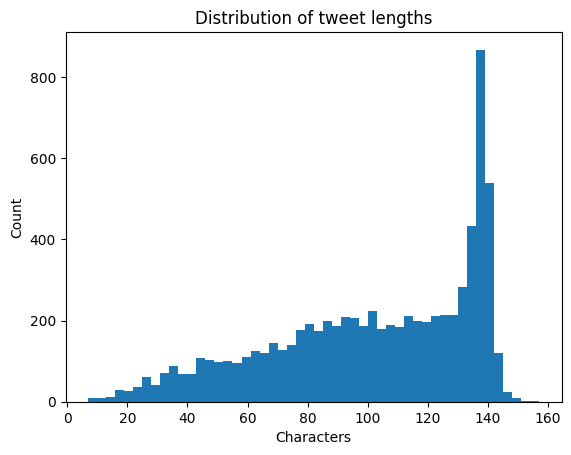

In [72]:
print(train_df['target'].value_counts())
train_df['text_len'] = train_df['text'].astype(str).apply(len)
print("Text length: min, median, max are", train_df['text_len'].min(), train_df['text_len'].median(), train_df['text_len'].max())

# Plot text length histogram
plt.hist(train_df['text_len'], bins=50)
plt.title("Distribution of tweet lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


target
0    4342
1    3271
Name: count, dtype: int64


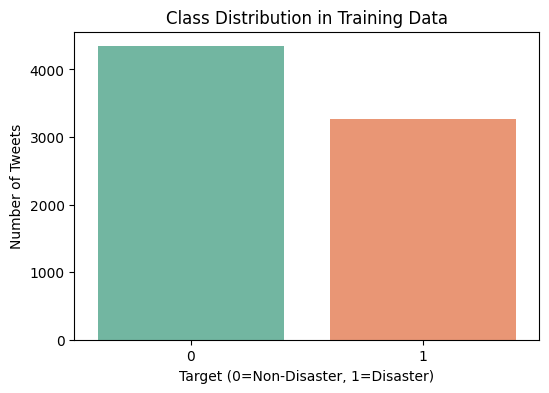

In [140]:
class_counts = train_df['target'].value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')
plt.title('Class Distribution in Training Data')
plt.xlabel('Target (0=Non-Disaster, 1=Disaster)')
plt.ylabel('Number of Tweets')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


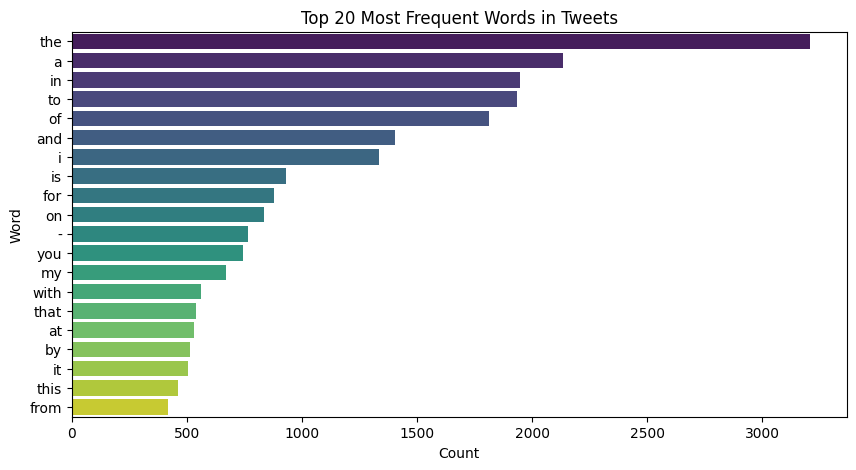

In [121]:
from collections import Counter
import seaborn as sns

# Flatten all words in the corpus
all_words = ' '.join(train_df['clean_text']).split()
word_freq = Counter(all_words)

# Get top 20 words
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Words in Tweets')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


<h2>Clean Data</h2>
Before training the model, it is important to clean the data to improve performance.

I removed new line characters (\n), URLs, mentions (@username), and extra whitespace, and converted all letters to lowercase.

In [73]:
# Data cleaning
def clean_text(text):
    text = str(text)
    text = text.replace('\n', ' ')
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # remove mentions
    text = re.sub(r'@\w+', '', text)
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # lower
    text = text.strip().lower()
    return text

train_df['clean_text'] = train_df['text'].astype(str).map(clean_text)
test_df['clean_text']  = test_df['text'].astype(str).map(clean_text)
train_df[['text', 'clean_text']].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


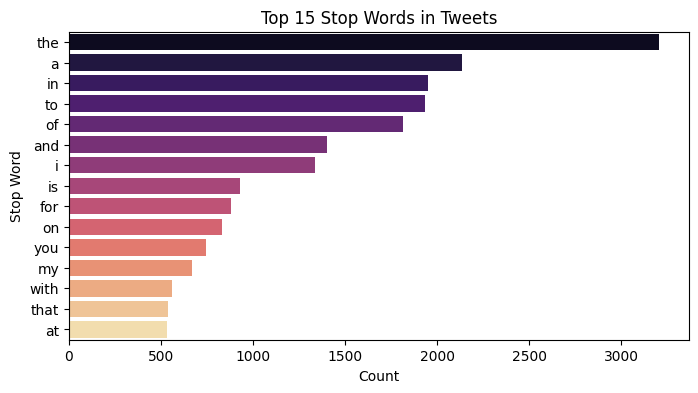

In [122]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Count stop words in tweets
stop_word_counts = Counter([word for word in all_words if word in stop_words])
top_stop_words = stop_word_counts.most_common(15)
sw_words, sw_counts = zip(*top_stop_words)

# Plot top stop words
plt.figure(figsize=(8,4))
sns.barplot(x=list(sw_counts), y=list(sw_words), palette='magma')
plt.title('Top 15 Stop Words in Tweets')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()

In [123]:
def remove_stop_words(text):
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

train_df['clean_text_nostop'] = train_df['clean_text'].apply(remove_stop_words)
test_df['clean_text_nostop']  = test_df['clean_text'].apply(remove_stop_words)

# Check result
train_df[['clean_text', 'clean_text_nostop']].head()


,clean_text,clean_text_nostop
0,our deeds are the reason of this #earthquake m...,deeds reason #earthquake may allah forgive us
1,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,all residents asked to 'shelter in place' are ...,residents asked 'shelter place' notified offic...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...,got sent photo ruby #alaska smoke #wildfires p...


<h2>Text to Token</h2>
I preprocess the text into tokens so that the model can understand it. 
I use Word2Vec because, unlike GloVe, it does not require extra loading and can be trained quickly on our dataset. TF-IDF cannot be used with LSTM, as it destroys the word order, while LSTM relies on the sequence of words. Word2Vec preserves the original word order, making it suitable for sequential models like LSTM and BiLSTM.

In [124]:
MAX_NB_WORDS = 20000
MAX_SEQ_LEN = 60
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df["clean_text_nostop"])

X = tokenizer.texts_to_sequences(train_df["clean_text_nostop"])
X = pad_sequences(X, maxlen=MAX_SEQ_LEN)

y = train_df["target"].values

X_test = tokenizer.texts_to_sequences(test_df["clean_text_nostop"])
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN)

In [125]:
sentences = [text.split() for text in train_df["clean_text_nostop"]]

w2v_model = Word2Vec(
    sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4
)

vocab_size = min(MAX_NB_WORDS, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


<h1>Model Architecture</h1>

<h2>LSTM model</h2>

I start with a basic LSTM model as a baseline. Evaluation using F1 since this is the performance metric that the competition is using.

LSTM (Long Short-Term Memory) networks are a type of RNN. In text data, the order of words is important for understanding context and meaning. LSTM can remember information from previous words in a sequence, making it suitable for tasks like disaster tweet classification, where certain keywords or patterns may indicate relevance.

Starting with a simple LSTM provides a reference point to compare more complex architectures, such as BiLSTM or models with additional dense layers and learning rates.

In [126]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)
print(X_train.shape)
print(X_val.shape)

(6851, 60)
(762, 60)


In [127]:
def tune_threshold(model, X_val, y_val, plot=False):
    y_prob = model.predict(X_val).ravel()
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []

    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thresholds, f1_scores)
        plt.axvline(best_t, color='r', linestyle='--', label=f"Best t={best_t:.2f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title("Threshold Tuning Curve")
        plt.legend()
        plt.show()

    return best_t, best_f1

In [128]:
# Set evaluation method to F1
def evaluate_model(name, model, X_val, y_val, plot=True):
    y_prob = model.predict(X_val).ravel()
    
    # Default threshold = 0.5
    y_pred_default = (y_prob >= 0.5).astype(int)
    f1_default = f1_score(y_val, y_pred_default)

    # Tuned threshold
    best_t, best_f1 = tune_threshold(model, X_val, y_val, plot=plot)

    print(f"\n===== {name} Evaluation =====")
    print(f"F1 @ threshold=0.5: {f1_default:.4f}")
    print(f"Best threshold: {best_t:.2f}")
    print(f"Best F1: {best_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, (y_prob >= best_t).astype(int))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix (t={best_t:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return best_t, best_f1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.6838 - val_loss: 0.6678
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.6657 - val_loss: 0.6624
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.6609 - val_loss: 0.6565
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


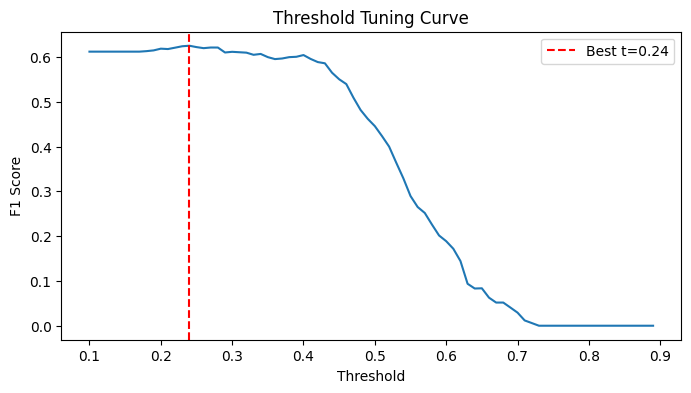


===== LSTM Evaluation =====
F1 @ threshold=0.5: 0.4457
Best threshold: 0.24
Best F1: 0.6252


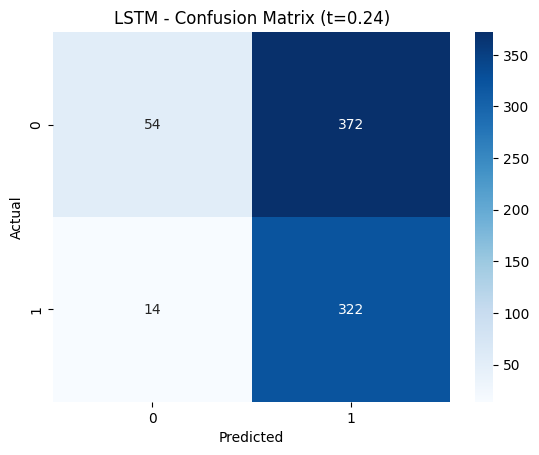

In [129]:
# Basic LSTM model
model_lstm = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(
    loss="binary_crossentropy",
    optimizer="adam"
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_lstm, best_f1_lstm = evaluate_model("LSTM", model_lstm, X_val, y_val)

<h1>Optimization</h1>
First round result of LSTM without optimization is 0.6262.

Next, I experimented with a more advanced architecture, the Bidirectional LSTM (BiLSTM). This model captures context from both past and future words in a sequence, but its initial score was 0.6168, slightly lower than the baseline LSTM.

To improve performance, I then fine-tuned various hyperparameters, including:

Smaller LSTM units

Adding dense layers after the LSTM/BiLSTM to better transform features

Adjusting the learning rate

Changing dropout rates

Setting the embedding layer as trainable

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.6835 - val_loss: 0.6663
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.6650 - val_loss: 0.6674
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.6608 - val_loss: 0.6585
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


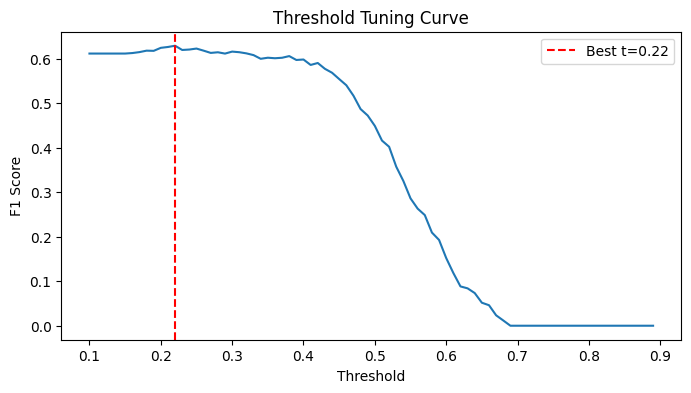


===== BiLSTM Evaluation =====
F1 @ threshold=0.5: 0.4494
Best threshold: 0.22
Best F1: 0.6296


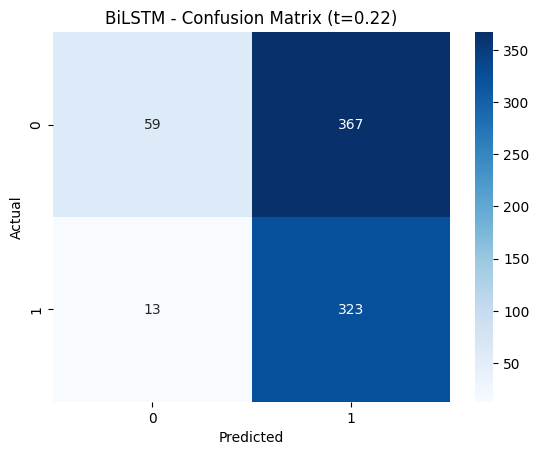

In [130]:
# Bi-directional LSTM model
model_bilstm = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

#Default learning rate 0.001
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm, best_f1_bilstm = evaluate_model("BiLSTM", model_bilstm, X_val, y_val)

<h1>Result and Analysis</h1>

I have conducted several experiments:

Smaller LSTM units: Reducing the BiLSTM units to 32 achieved an F1 score: 0.6169, showing that smaller models can slightly reduce overfitting but did not drastically improve performance.

Trainable embeddings: Making the Word2Vec embeddings trainable, get the score: 0.6120, slightly lower, suggesting that trainable learning may not help in the case.

Adding dense layers and dropout: Introducing additional dense layers with dropout significantly improved performance, reaching an F1 score of 0.7480. This demonstrates that transforming features after the recurrent layer and applying regularization helps the model generalize better.

Learning rate tuning: Further adjusting the learning rate to 5e-4 on the dense-layer version boosted the F1 to 0.7618, showing that smaller learning rate also helps.

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.6860 - val_loss: 0.7403
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.6742 - val_loss: 0.6648
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.6668 - val_loss: 0.6598
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


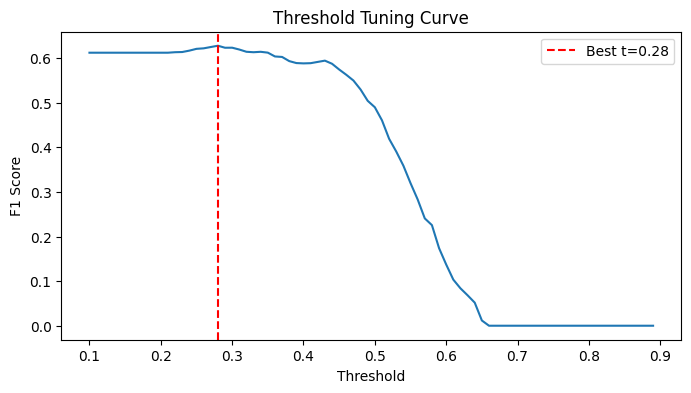


===== BiLSTM_32) Evaluation =====
F1 @ threshold=0.5: 0.4897
Best threshold: 0.28
Best F1: 0.6277


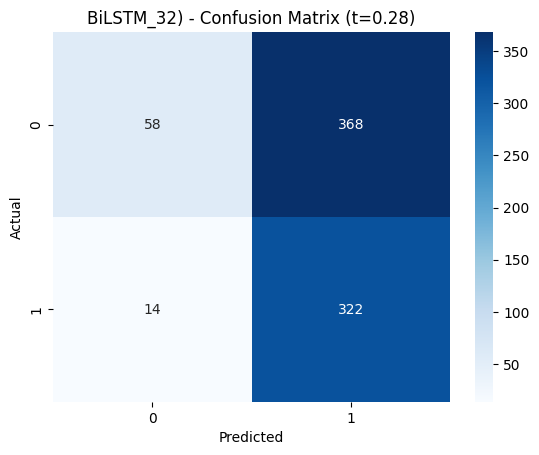

In [131]:
# Smaller unit2 Bi-LSTM , 64->32
model_bilstm_32 = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_bilstm_32.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm_32 = model_bilstm_32.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm_32, best_f1_bilstm_32 = evaluate_model("BiLSTM_32)", model_bilstm_32, X_val, y_val)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.6583 - val_loss: 0.6523
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.6552 - val_loss: 0.6439
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.6474 - val_loss: 0.6367
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


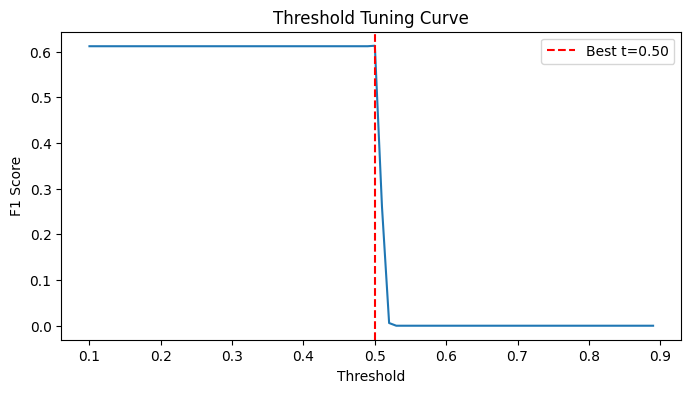


===== BiLSTM_trainable Evaluation =====
F1 @ threshold=0.5: 0.6131
Best threshold: 0.50
Best F1: 0.6131


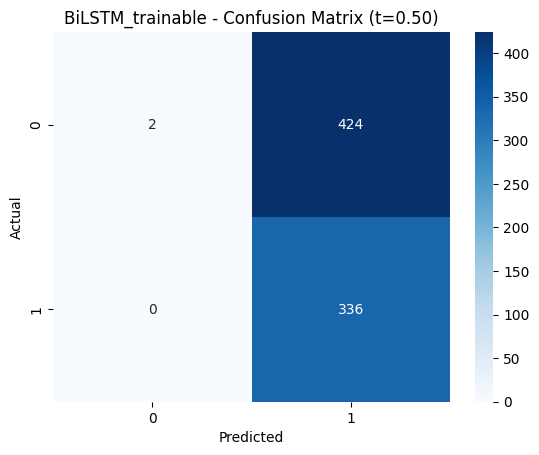

In [132]:
# Set the embedding layer as trainable so Word2Vec embeddings could adapt to the dataset
model_bilstm_trainable = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_bilstm_trainable.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm_trainable = model_bilstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm_trainable, best_f1_bilstm_trainable = evaluate_model("BiLSTM_trainable", model_bilstm_trainable, X_val, y_val)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.6637 - val_loss: 0.4869
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.3791 - val_loss: 0.5716
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.2144 - val_loss: 0.7365
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


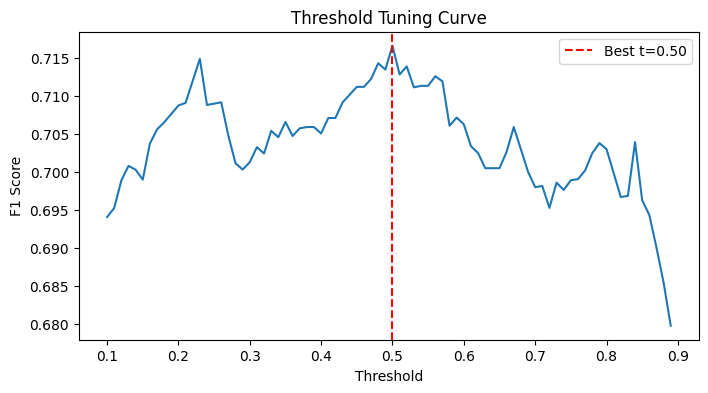


===== BiLSTM_Dense Evaluation =====
F1 @ threshold=0.5: 0.7166
Best threshold: 0.50
Best F1: 0.7166


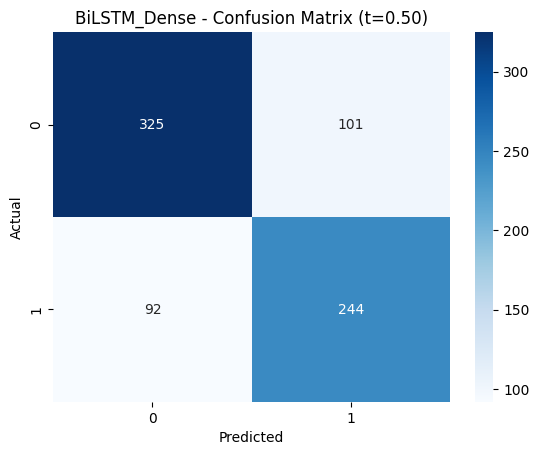

In [133]:
# Adding dense layers
model_dense = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dense.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_dense = model_dense.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_dense, best_f1_dense = evaluate_model("BiLSTM_Dense", model_dense, X_val, y_val)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.6783 - val_loss: 0.6078
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.4556 - val_loss: 0.5139
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.2619 - val_loss: 0.6510
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


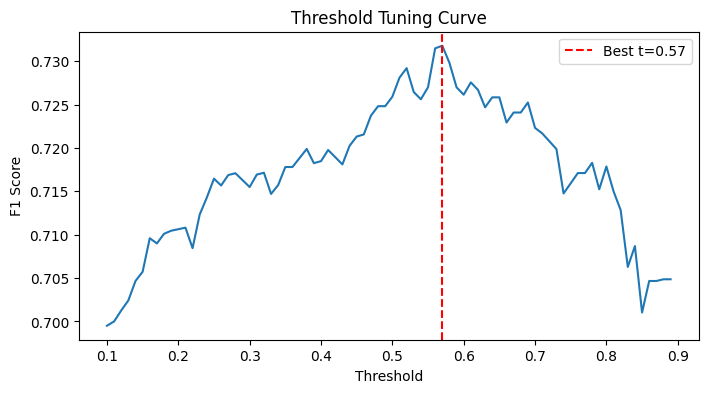


===== BiLSTM_lr Evaluation =====
F1 @ threshold=0.5: 0.7259
Best threshold: 0.57
Best F1: 0.7318


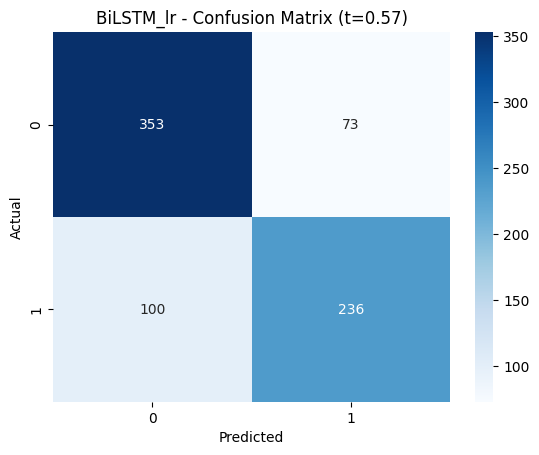

In [134]:
#Modifying learning rate
from tensorflow.keras.optimizers import Adam

model_lr = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lr.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=5e-4))

history_lr = model_lr.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_lr, best_f1_lr = evaluate_model("BiLSTM_lr", model_lr, X_val, y_val)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.6802 - val_loss: 0.5809
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.4503 - val_loss: 0.5185
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.2561 - val_loss: 0.6168
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.1656 - val_loss: 0.7146
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.1143 - val_loss: 0.7936
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


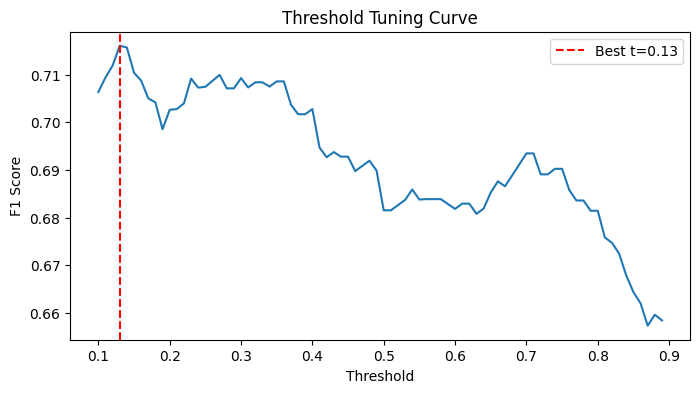


===== BiLSTM_lr_epo Evaluation =====
F1 @ threshold=0.5: 0.6815
Best threshold: 0.13
Best F1: 0.7161


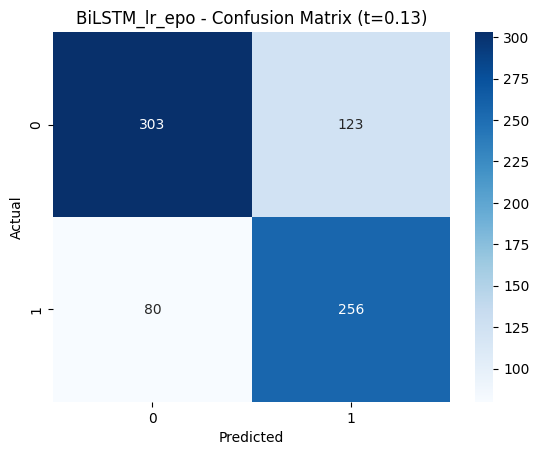

In [135]:
#Modifying learning rate with more epochs
from tensorflow.keras.optimizers import Adam

model_lr_epo = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lr_epo.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=5e-4))

history_lr_epo = model_lr_epo.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_data=(X_val, y_val)
)

best_t_lr_epo, best_f1_lr_epo = evaluate_model("BiLSTM_lr_epo", model_lr_epo, X_val, y_val)

In [136]:
results_f1 = [
    ["LSTM", best_t_lstm, best_f1_lstm],
    ["BiLSTM", best_t_bilstm, best_f1_bilstm],
    ["BiLSTM_32", best_t_bilstm_32, best_f1_bilstm_32],
    ["BiLSTM_Dense", best_t_dense, best_f1_dense],
    ["BiLSTM_lr", best_t_lr, best_f1_lr],
    ["BiLSTM_trainable", best_t_bilstm_trainable, best_f1_bilstm_trainable],
    ["BiLSTM_lr_epo", best_t_lr_epo, best_f1_lr_epo]
]

results_f1_df = pd.DataFrame(results_f1, columns=["Model", "Best Threshold", "Best F1"])
results_f1_df.sort_values("Best F1", ascending=False)


,Model,Best Threshold,Best F1
4,BiLSTM_lr,0.57,0.731783
3,BiLSTM_Dense,0.50,0.716593
6,BiLSTM_lr_epo,0.13,0.716084
1,BiLSTM,0.22,0.629630
2,BiLSTM_32,0.28,0.627680
0,LSTM,0.24,0.625243
5,BiLSTM_trainable,0.50,0.613139


In [137]:
best_row = results_f1_df.sort_values("Best F1", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_t = best_row["Best Threshold"]

print("Best model:", best_model_name)
print("Best validation F1:", best_row["Best F1"])
print("Using threshold:", best_t)



Best model: BiLSTM_lr
Best validation F1: 0.7317829457364341
Using threshold: 0.5699999999999997


In [138]:
best_model = model_lr

y_test_prob = best_model.predict(X_test).ravel()
y_test_pred = (y_test_prob >= best_t).astype(int)

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": y_test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


<h1>Conclusion</h1>
In this project, I explored various neural network architectures for disaster tweet classification using Word2Vec embeddings and sequential models. Starting with a basic LSTM model as a baseline.

Then I have experimented with more advanced architectures, including Bidirectional LSTM and BiLSTM with additional dense layers.

It is surprising that a simple basic LSTM provided a strong baseline with a decent F1 score.

The problem I was still confused about is that I thought bi-directional LSTM should perform better, but the actual F1 score is slightly lower. Because of the tweet, the past and future words should play important roles.

My guess is the tweets are too short, maybe the backward pass doesn't add much useful insight.

Furthermore, maybe we can try attention models or LLM to test if they can achieve better results.



<h1>Reference</h1>
KerasNLP starter notebook Disaster Tweets:  https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook

Word2Vec: https://www.tensorflow.org/text/tutorials/word2vec



<h1>Github Link</h1>
https://github.com/meng-shi/Natural-Language-Processing-with-Disaster-Tweets